In [1]:
import os
import numpy as np
from scipy.stats import norm, uniform 
from scipy.stats import gaussian_kde as kde 
import matplotlib.pyplot as plt

In [2]:
####### Plot Formatting ######
plt.rc('lines', linewidth = 4)
plt.rc('xtick', labelsize = 13)
plt.rc('ytick', labelsize = 13)
plt.rc('legend',fontsize=14)
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['lines.markersize'] = 8
plt.rcParams['figure.figsize'] = (7.0, 5.0)

In [3]:
#### To make it cleaner, create Directory "images" to store all the figures ####
imagepath = os.path.join(os.getcwd(),"images")
os.makedirs(imagepath,exist_ok=True)

 A simple example in Python: The Spaces, QoI, and Densities
___


* $\Lambda=[-1,1]$.

* $Q(\lambda) = \lambda^p$ for $p=5$.

* $\mathcal{D} = Q(\Lambda) = [-1,1]$.

___

* $\pi_{\Lambda}^{initial} \sim U([-1,1])$

* $\pi_{\mathcal{D}}^{obs} \sim N(\mu,\sigma^2)$
    * Initially take $\mu=0.25$ and $\sigma=0.1$.

* $\pi_{\mathcal{D}}^{predict}$ 
    * Known in this case.

In [4]:
def QoI(lam,p): # defing a QoI mapping function
    q = lam**p
    return q

In [5]:
N, mu, sigma = int(1E4), 0.25, 0.1 # number of samples from initial and observed mean (mu) and st. dev (sigma)
np.random.seed(12345)
lam = np.random.uniform(low=-1,high=1,size=N) # sample set of the initial

# Evaluate the QoI map on this initial sample set
qvals_nonlinear = QoI(lam,5) # Evaluate lam^5 samples

# Estimate the push-forward density for the QoI
q_nonlinear_kde = kde( qvals_nonlinear )

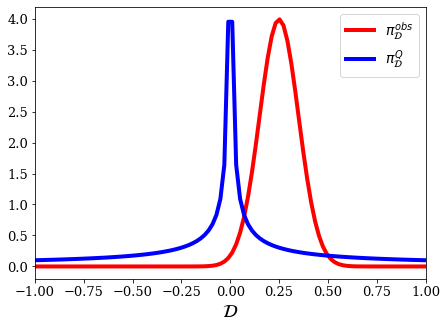

In [6]:
fig = plt.figure() # Plot the push-forward of the initial and observed densities
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', label="$\pi_\mathcal{D}^{Q}$")

plt.xlim([-1,1]) 
plt.xlabel("$\mathcal{D}$")
plt.legend()
plt.show();
fig.savefig("images/Background_pf.png")

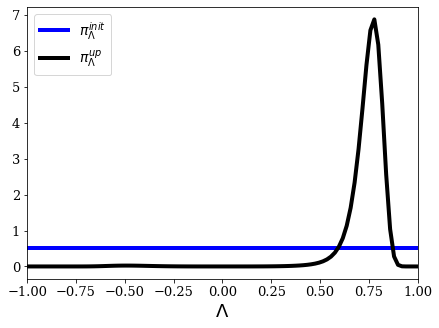

In [7]:
fig = plt.figure() # Plot the initial and posterior
lam_plot = np.linspace(-1,1, num=100)
initial_plot = plt.plot(lam_plot,uniform.pdf(lam_plot, loc=-1, scale=2), 'b-', label="$\pi_\Lambda^{init}$")
pullback_plot = plt.plot(lam_plot,uniform.pdf(lam_plot, loc=-1, scale=2)*\
                         norm.pdf(QoI(lam_plot,5), loc=mu, scale=sigma)/(1/10*np.abs(QoI(lam_plot,5))**(-4/5)),'k-', label="$\pi_\Lambda^{up}$")
plt.xlim([-1,1])
plt.xlabel("$\Lambda$")
plt.legend()
plt.show();
fig.savefig("images/Background_pdf_on_lam.png")

In [8]:
def rejection_sampling(r):
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

In [9]:
# Evaluate the observed density on the QoI sample set
obs_vals_nonlinear = norm.pdf(qvals_nonlinear, loc=mu, scale=sigma)

# Compute r
r_nonlinear = np.divide(obs_vals_nonlinear,1/10*np.abs(qvals_nonlinear)**(-4/5))

# Perform rejection sampling
samples_to_keep_nonlinear = rejection_sampling(r_nonlinear)
post_lam_nonlinear = lam[samples_to_keep_nonlinear]

# Construct push-forward of the pullback density
post_q_nonlinear = qvals_nonlinear[samples_to_keep_nonlinear] 
postq_nl_kde = kde( post_q_nonlinear ) 

weighted KDE

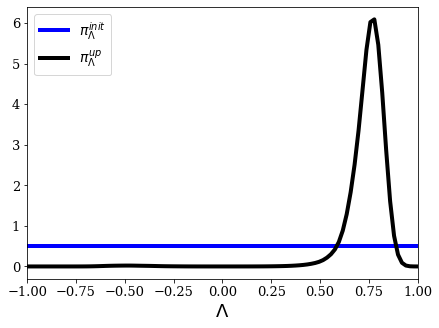

In [10]:
pdf_update = kde(lam, weights=r_nonlinear)

fig = plt.figure() # Plot the initial and posterior
lam_plot = np.linspace(-1,1, num=100)
initial_plot = plt.plot(lam_plot,uniform.pdf(lam_plot, loc=-1, scale=2), 'b-', label="$\pi_\Lambda^{init}$")
pullback_plot = plt.plot(lam_plot,pdf_update(lam_plot),'k-', label="$\pi_\Lambda^{up}$")
plt.xlim([-1,1])
plt.xlabel("$\Lambda$")
plt.legend()
plt.show();
fig.savefig("images/Background_pdf_on_lam2.png")

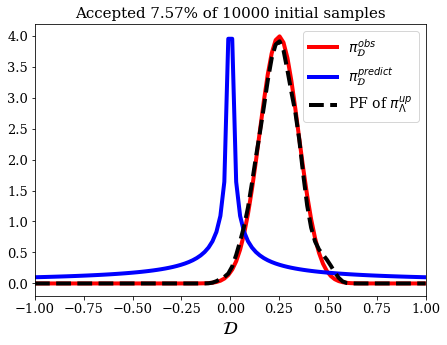

In [11]:
fig = plt.figure() # Plot the push-forward of the initial, observed density, and push-forward of pullback
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', label="$\pi_\mathcal{D}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nl_kde(qplot),'k--', label="PF of $\pi_\Lambda^{up}$")
plt.xlim([-1,1])
plt.xlabel("$\mathcal{D}$")
plt.legend()
title_str = 'Accepted %4.2f' %(post_q_nonlinear.size/N*100) +'% of ' + str(N) + ' initial samples'
plt.title(title_str)
plt.show();
fig.savefig("images/Background_comp_on_D.png")

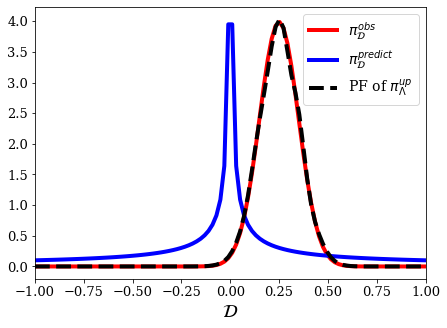

In [12]:
## Weighted kde
postq_nl_kde2 = kde( qvals_nonlinear, weights=r_nonlinear) 

fig = plt.figure() # Plot the push-forward of the initial, observed density, and push-forward of pullback
qplot = np.linspace(-1,1, num=100)
observed_plot = plt.plot(qplot,norm.pdf(qplot, loc=mu, scale=sigma), 'r-', label="$\pi_\mathcal{D}^{obs}$")
pf_initial_plot = plt.plot(qplot,1/10*np.abs(qplot)**(-4/5),'b-', label="$\pi_\mathcal{D}^{predict}$")
pf_post_plot = plt.plot(qplot,postq_nl_kde2(qplot),'k--', label="PF of $\pi_\Lambda^{up}$")
plt.xlim([-1,1])
plt.xlabel("$\mathcal{D}$")
plt.legend()
plt.show();
fig.savefig("images/Background_comp_on_D2.png")